In [1]:
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
import astropy.units as u
import os
import sys
import time
from scipy.stats import chisquare
from datetime import datetime
from astropy.coordinates import SkyCoord
#import ConfigParser as cp
import matplotlib
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import emcee
import MulensModel as mm
from MulensModel.utils import Utils

In [2]:
class color:
   PURPLE = '\033[1;35;48m'
   CYAN = '\033[1;36;48m'
   BOLD = '\033[1;37;48m'
   BLUE = '\033[1;34;48m'
   GREEN = '\033[1;32;48m'
   YELLOW = '\033[1;33;48m'
   RED = '\033[1;31;48m'
   BLACK = '\033[1;30;48m'
   UNDERLINE = '\033[4;37;48m'
   END = '\033[1;37;0m'

In [3]:
local_path='/Users/adrianhernandez/JPL_2021/'
sys.path.append(local_path + 'MulensModel_master/source')
import MulensModel as mm
from MulensModel.utils import Utils

In [4]:
##import data 

import sys
import os

local_path='/Users/adrianhernandez/JPL_2021/'
sys.path.append(local_path + 'MulensModel_master/source')
#
import MulensModel as mm
import numpy as np
import matplotlib.pyplot as pl
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
#
from glob import glob
dir_casu = '/Users/adrianhernandez/JPL_2021/ukirt_casu/'
casu_data = glob(f"{dir_casu}/*C58505*.txt")
#
# # fln = casu_data[0][44:77]
# # print(fln)
ukirt_casu_H = np.loadtxt(casu_data[0], usecols=range(3)) #H band data
ukirt_casu_K = np.loadtxt(casu_data[2], usecols=range(3)) # K band data
H_data = mm.MulensData(file_name=casu_data[0]) #used only for the mulens code
K_data = mm.MulensData(file_name=casu_data[2])




In [9]:
#create arrays for time, magnitude, and error 
ukirt_time = ukirt_data[:,0]-2450000 # - 2450000 for ukirt data 
reg_ukirt_time = ukirt_data[:,0]
ukirt_mag = ukirt_data[:,1]
ukirt_error = ukirt_data[:,2]
data_points = len(ukirt_data)
print(type(ukirt_error))

<class 'numpy.ndarray'>


[2457864.0234  2457864.06234 2457864.10809 2457865.01801 2457865.09974
 2457878.01535 2457878.05993 2457878.10358 2457878.98489 2457879.02471
 2457879.0758  2457879.99268 2457880.08285 2457880.98613 2457881.02878
 2457881.07256 2457882.00427 2457882.00557 2457882.00688 2457882.97179
 2457883.05724 2457883.98717 2457884.02752 2457884.07875 2457885.00357
 2457885.04385 2457885.09327 2457885.9969  2457886.08692 2457887.00892
 2457887.01022 2457887.01152 2457890.94767 2457890.98933 2457891.03284
 2457891.94944 2457892.03774 2457892.95248 2457892.99106 2457893.04261
 2457893.96892 2457893.97024 2457893.97154 2457894.93733 2457895.07324
 2457897.94676 2457898.03613 2457898.98999 2457898.99128 2457898.9926
 2457899.96734 2457900.00643 2457900.05628 2457900.94154 2457901.03218
 2457901.95474 2457902.00201 2457902.05546 2457902.94231 2457903.92715
 2457904.02455 2457904.94897 2457904.98758 2457905.03669 2457905.92574
 2457905.96427 2457906.01848 2457907.93389 2457907.97234 2457908.02439
 245790

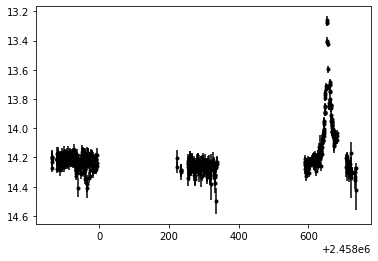

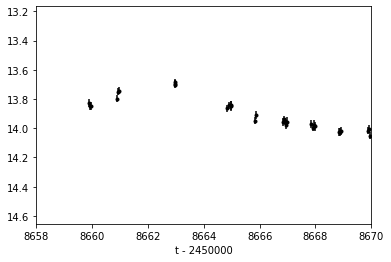

In [7]:
# Plot the data and look for light curve pertubations 
pl.errorbar(K_data.time, K_data.mag, yerr=K_data.err_mag, fmt='.k')
pl.gca().invert_yaxis()
pl.show()

# ***Define plot limits for a zoom (of the planetary perturbation)***
(t_min, t_max) = (2458658.,2458670.)

# Plot a zoom of the data
pl.errorbar(K_data.time-2450000, K_data.mag, yerr=K_data.err_mag, fmt='.k')
pl.xlim(t_min - 2450000., t_max - 2450000.)
pl.xlabel('t - 2450000')
pl.gca().invert_yaxis()
pl.show()

In [86]:
base_est = np.mean(ukirt_mag[300:583]) 
print(color.BLUE +'Estimated Baseline magnification ='+ color.END,base_est)
peak_est = min(ukirt_mag)
print(color.BLUE +'Estimated Event peak magnification ='+ color.END,peak_est)
del_mag_est = base_est - peak_est 
print(color.BLUE +'Estimated Change in magnification ='+ color.END,del_mag_est)
to_est = ukirt_time[ukirt_mag.argmin()]+2450000 #2458588.82653
print(color.BLUE +'Estimated Time at which peak magnification occurs ='+ color.END,to_est)
A_FWHM = (base_est + peak_est)/2
print(color.BLUE +'FWHM occurs at'+ color.END,A_FWHM)
width = np.full((1,data_points),A_FWHM)
idx = np.argwhere(np.diff(np.sign(width - ukirt_mag))).flatten()
print(ukirt_time[idx])
FWHM = ukirt_time[idx][7]-ukirt_time[idx][0]
print(color.BLUE +'The estimated FWHM is'+ color.END,FWHM)
sig_est = FWHM/2.355
print(color.BLUE +'The estimated simga is'+ color.END,sig_est)

Estimated Baseline magnification = 16.270862903225808
Estimated Event peak magnification = 12.019
Estimated Change in magnification = 4.251862903225808
Estimated Time at which peak magnification occurs = 2457917.90594
FWHM occurs at 14.144931451612905
[7864.0234  7899.96734 7864.0234  7900.00643 7864.0234  7900.05628
 7864.0234  7931.94805]
The estimated FWHM is 67.92464999994263
The estimated simga is 28.842738853478824


In [87]:
A = 10**((del_mag_est)/2.5) 
print(color.PURPLE +'Magnification increased by'+ color.END,A)
u0_est = 1/A
print(color.PURPLE +'Estimated minimum event separation, u0 ='+ color.END,u0_est)
t0_est = ukirt_time[ukirt_mag.argmin()]+2450000 #2458588.82653
print(color.PURPLE +'Estimated Time at which peak magnification occurs, t0 ='+ color.END,t0_est)
width = np.full((1,data_points),A_FWHM)
idx = np.argwhere(np.diff(np.sign(width - ukirt_mag))).flatten()
print(ukirt_time[idx])
tE_est = ukirt_time[idx][7]-ukirt_time[idx][0]
print(color.PURPLE +'The estimated Einstein crossing time is, tE'+ color.END,tE_est)

Magnification increased by 50.20479074787639
Estimated minimum event separation, u0 = 0.01991841784625502
Estimated Time at which peak magnification occurs, t0 = 2457917.90594
[7864.0234  7899.96734 7864.0234  7900.00643 7864.0234  7900.05628
 7864.0234  7931.94805]
The estimated Einstein crossing time is, tE 67.92464999994263


## Fitting PSPL parameters using MCMC

original PARAMS:  {'u0': 0.01991841784625502, 't0': 7917.905939999968, 'tE': 67.92464999994263, 'Ftot': 16.0585, 'fb': 0.99, 'chi2': 1, 'chi2red': 1}
initializing walkers
('OK: smaller range2 for JD init', 7917.905939999968)
running mcmc for ground-based data
 setting the burn in
 doing the final run
(' Acceptance fraction:', 0.6166666666666667)
 not doing the autocorr check.  trouble here!
('FIT RESULT:', '      u0', '=', '      0.0201', '+-', ' 0.00047')
(' | chi offset =', ' 0.34')
  0.0
('FIT RESULT:', '      tE', '=', '    108.9584', '+-', ' 0.91781')
(' | chi offset =', '44.71')
  0.0
('FIT RESULT:', '      t0', '=', '   7916.0042', '+-', ' 0.04278')
(' | chi offset =', '-44.45')
  0.0
('FIT RESULT:', '    Ftot', '=', '     16.2526', '+-', ' 0.00204')
(' | chi offset =', '95.06')
  0.0
('FIT RESULT:', '      fb', '=', '      0.9930', '+-', ' 0.00703')
(' | chi offset =', ' 0.43')
  0.0
None
bestIndex 14072
 param old,new values: u0 0.020077717106857185 0.02028257772376162
 param 

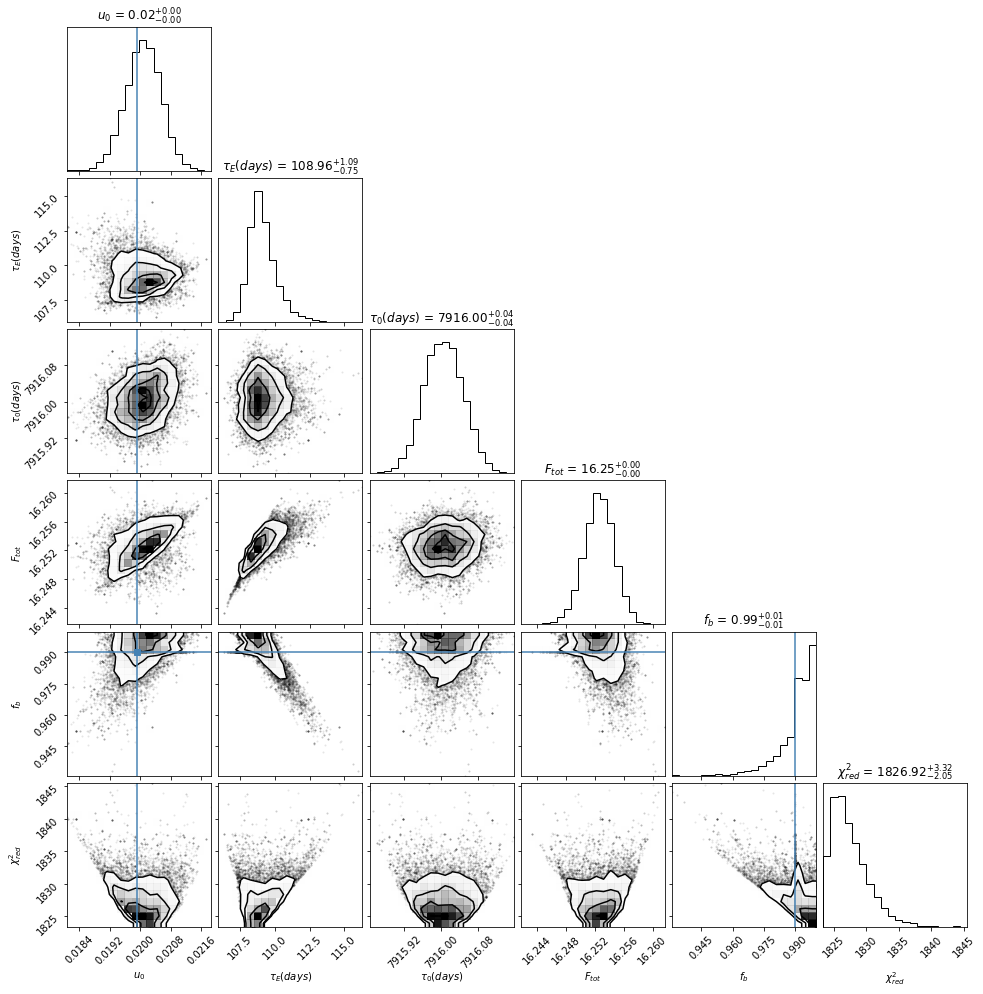

In [88]:
import mcmcFit as mcfit

u0,t0,tE,Ftot,fb,u0err,t0err,tEerr,Ftoterr,fberr = mcfit.mcmcFit(filename,ukirt_time,ukirt_mag,ukirt_error,u0_est,t0_est-2450000,tE_est)

print('u0, error',u0,u0err)
print('t0, error',t0,t0err)
print('tE, error',tE,tEerr)
print('Ftot, error',Ftot,Ftoterr)
print('Fb, error',fb,fberr)

In [89]:
print(t0,u0,tE)

7916.010846976689 0.02028257772376162 108.37867139309836


In [90]:
pspl_model = mm.Model({'t_0': t0+2450000, 'u_0': u0, 't_E': tE})
print(color.BLUE +'Fitted PSPL parameters'+ color.END)
print(pspl_model)
# pspl_model.plot_magnification(
#     t_range=[2457895, 2457940], subtract_2450000=True, color='red', 
#     linestyle=':', label='PSPL')
# pl.legend(loc='best')
# pl.show()
pspl_event = mm.Event(datasets=data, model=pspl_model)


Fitted PSPL parameters
    t_0 (HJD)       u_0    t_E (d) 
2457916.01085  0.020283   108.3787 



In [8]:
# ***Set time range of planetary perturbation (including 2460000).***
(t_planet_start, t_planet_stop) = (2458658,2458670)


# *Set the magnification methods for the planet model*
# VBBL method will be used between t_planet_start and t_planet_stop, 
# and point_source_point_lens will be used everywhere else.
magnification_methods = [
    0., 'point_source_point_lens', 
    t_planet_start, 'VBBL', t_planet_stop, 
    'point_source_point_lens', 2460000.]

# # Flag data related to the planet
# flag_planet = (data.time > t_planet_start) & (data.time < t_planet_stop) | np.isnan(data.err_mag)

# # Exclude those data from the fitting (for now)
# data.bad = flag_planet

In [11]:
# Estimate s (projected separation) of the planet, alpha (angle of source trajectory)

# Approximate time of the planetary perturbation
t_planet = (t_planet_stop + t_planet_start) / 2.

# Position of the source at the time of the planetary perturbation
tau_planet = ((t_planet - (8653.539+2450000)) /50.212)
u_planet = np.sqrt((0.0362)**2 + tau_planet**2)

# Position of the lens images at the time of the planetary perturbation
# --> Estimate of the planet location
s_minus = 0.5 * (np.sqrt(u_planet**2 + 4.) - u_planet)
s_plus = 0.5 * (np.sqrt(u_planet**2 + 4.) + u_planet)


#Angle between the source trajectory and the binary axis
#***I dont think this works well for small u0***
alpha_planet = np.rad2deg(-np.arctan2(0.0362, tau_planet))

print('Est u_planet = ',u_planet)
print('Est s_minus = ', s_minus, 'Est s_plus=', s_plus)
print('Est alpha =', alpha_planet)

Est u_planet =  0.21145827204134102
Est s_minus =  0.8998446555051813 Est s_plus= 1.1113029275465223
Est alpha = -9.857141441046707


In [93]:
#q can be estimated with the FWHM of the planetary perturbation. 
# if the FWHM of the planetary perturbation is not clear then q = 10^(-3) is a good estimate 

In [94]:
planet_test_model = mm.Model({
    't_0': t0+2450000, 
    'u_0': u0,
    't_E': tE,
    'rho': 10.**(-3),
    's': s_plus,
    'q': 10.**(-3),
    'alpha': alpha_planet})
planet_test_model.set_magnification_methods(magnification_methods)
planet_test_event = mm.Event(datasets=data, model= planet_test_model)
print(planet_test_event.model)

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
2457916.01085  0.020283   108.3787 0.00100   1.02123   0.00100000   -28.85670 



In [95]:
#Define fitting functions

def chi2_fun(theta, event, parameters_to_fit):
    """                                                                         
    Chi2 function. Changes values of the parameters and recalculates chi2.
    
    event = a MulensModel.Event
    parameters_to_fit = list of names of parameters to be changed
    theta = values of the corresponding parameters
    """
    # key = the name of the MulensModel parameter
    for (index, key) in enumerate(parameters_to_fit):
        if (key == 't_E' or key =='rho') and theta[index] < 0.:
            return np.inf
        setattr(event.model.parameters, key, theta[index])
    return event.get_chi2()

def fit_model(event, parameters_to_fit):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)

    # *Execute fit using a 'Nelder-Mead' algorithm*
    result = op.minimize(
        chi2_fun, x0=x0, args=(event, parameters_to_fit),
        method='Nelder-Mead')

    return result

In [105]:
result = fit_model(pspl_event, parameters_to_fit=['t_0', 'u_0', 't_E'])
print(pspl_event.model.parameters)


    t_0 (HJD)       u_0    t_E (d) 
2457916.55794  0.059282    67.2445 

2457916.557938492


In [108]:
# Using the Point Lens fit as input, search for a planetary solution
#
# Grid parameters: s (log), q (log)
# Fit parameters: rho, alpha
# PSPL parameters: t_0, u_0, t_E
#

# *Define the grid*
delta_log_s = 0.001
delta_log_q = 0.25
grid_log_s = np.hstack(
    (np.arange(
        np.log10(s_minus) - 0.02, np.log10(s_minus) + 0.02, delta_log_s),
    np.arange(
        np.log10(s_plus) - 0.02, np.log10(s_plus) + 0.02, delta_log_s)))
grid_log_q = np.arange(-5, -2, delta_log_q)

print(grid_log_s)
print(grid_log_q)

[-0.02912514 -0.02812514 -0.02712514 -0.02612514 -0.02512514 -0.02412514
 -0.02312514 -0.02212514 -0.02112514 -0.02012514 -0.01912514 -0.01812514
 -0.01712514 -0.01612514 -0.01512514 -0.01412514 -0.01312514 -0.01212514
 -0.01112514 -0.01012514 -0.00912514 -0.00812514 -0.00712514 -0.00612514
 -0.00512514 -0.00412514 -0.00312514 -0.00212514 -0.00112514 -0.00012514
  0.00087486  0.00187486  0.00287486  0.00387486  0.00487486  0.00587486
  0.00687486  0.00787486  0.00887486  0.00987486 -0.01087486 -0.00987486
 -0.00887486 -0.00787486 -0.00687486 -0.00587486 -0.00487486 -0.00387486
 -0.00287486 -0.00187486 -0.00087486  0.00012514  0.00112514  0.00212514
  0.00312514  0.00412514  0.00512514  0.00612514  0.00712514  0.00812514
  0.00912514  0.01012514  0.01112514  0.01212514  0.01312514  0.01412514
  0.01512514  0.01612514  0.01712514  0.01812514  0.01912514  0.02012514
  0.02112514  0.02212514  0.02312514  0.02412514  0.02512514  0.02612514
  0.02712514  0.02812514]
[-5.   -4.75 -4.5  -4.25 

In [109]:

# For each grid point, fit for rho, alpha
grid = np.empty((5, len(grid_log_s) * len(grid_log_q)))
i = 0
print('{0:>12} {1:>6} {2:>7} {3:>7} {4:>7}'.format('chi2', 's', 'q', 'alpha', 'rho'))
for log_s in grid_log_s:
    for log_q in grid_log_q:
        # The major and minor images are on opposite sides of the lens:
        if log_s < 0.:
            alpha = alpha_planet + 180.
        else:
            alpha = alpha_planet
            
        # Define the Model and Event
        planet_model = mm.Model({
            't_0': pspl_event.model.parameters.t_0, 
            'u_0': pspl_event.model.parameters.u_0,
            't_E': pspl_event.model.parameters.t_E,
            'rho': 0.001,
            's': 10.**log_s,
            'q': 10.**log_q,
            'alpha': alpha})
        planet_model.set_magnification_methods(magnification_methods)
        planet_event = mm.Event(datasets = data, model=planet_model)
            
        # Fit the Event
        result = fit_model(planet_event, parameters_to_fit=['rho', 'alpha'])
        if result.success:
            chi2 = planet_event.get_chi2()
        else:
            chi2 = np.inf
                
        # Print and store result of fit
        print('{0:12.2f} {1:6.4f} {2:7.5f} {3:7.2f} {4:7.5f}'.format(
            chi2, 10.**log_s, 10.**log_q, 
            planet_event.model.parameters.alpha, planet_event.model.parameters.rho))
        grid[0, i] = log_s
        grid[1, i] = log_q
        grid[2, i] = chi2
        grid[3, i] = planet_event.model.parameters.alpha.value
        grid[4, i] = planet_event.model.parameters.rho
            
        i += 1

        chi2      s       q   alpha     rho
      762.99 0.9351 0.00001  158.70 deg 0.00100
      762.99 0.9351 0.00002  158.70 deg 0.00100
      762.99 0.9351 0.00003  158.70 deg 0.00100
      762.99 0.9351 0.00006  158.70 deg 0.00100
      762.99 0.9351 0.00010  158.70 deg 0.00100
      762.99 0.9351 0.00018  158.70 deg 0.00100
      762.99 0.9351 0.00032  158.70 deg 0.00100
      762.99 0.9351 0.00056  158.70 deg 0.00100
      762.99 0.9351 0.00100  158.70 deg 0.00100
      762.99 0.9351 0.00178  158.70 deg 0.00100
      762.99 0.9351 0.00316  158.70 deg 0.00100
      762.99 0.9351 0.00562  158.70 deg 0.00100
      762.99 0.9373 0.00001  158.70 deg 0.00100
      762.99 0.9373 0.00002  158.70 deg 0.00100
      762.99 0.9373 0.00003  158.70 deg 0.00100
      762.99 0.9373 0.00006  158.70 deg 0.00100
      762.99 0.9373 0.00010  158.70 deg 0.00100
      762.99 0.9373 0.00018  158.70 deg 0.00100
      762.99 0.9373 0.00032  158.70 deg 0.00100
      762.99 0.9373 0.00056  158.70 deg 0.00

KeyboardInterrupt: 